In [1]:
from google.cloud import bigquery
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.lines import Line2D

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [3]:
client = bigquery.Client(project='subugoe-collaborative')

In [38]:
openalex = 'subugoe-collaborative.openalex'
s2 = 'subugoe-wag-closed.S2AG'
pm = 'subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022'
cr = 'subugoe-collaborative.cr_instant.snapshot'

In [31]:
openalex_type_mapping = {
    'journal': {
        'editorial_discourses': ['erratum', 'editorial', 'letter', 'paratext'],
        'research_discourse': ['article', 'dissertation']
    }
}

In [32]:
s2_type_mapping = {
    'journal': {
        'editorial_discourses': ['Editorial', 'News', 'LettersAndComments'],
        'research_discourse': ['Review', 'MetaAnalysis', 'JournalArticle', 'Study', 'CaseReport', 'ClinicalTrial']
    }
}

In [7]:
def mapping_types(mapping_dict, type):
    for k, v in mapping_dict.items():
        if type in v:
            return k

In [8]:
def alluvial_plot(df, db1_column_name, db2_column_name, db1_name, db2_name, image_name, width, height):
    df.fillna('other', inplace=True)
    d = {}
    for row in df.to_dict('records'):
        db1_type = row[db1_column_name] + ' (' + db1_name + ')'
        db2_type = row[db2_column_name] + ' (' + db2_name + ')'
        n = row['n']
    
        dd = {}
        dd[db2_type] = n
        
        if db1_type in d:
            d[db1_type].update(dd)
        else:
            d[db1_type] = dd

    d = {k + ' ': v for k, v in d.items()}

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    #fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [9]:
def alluvial_plot_new_types(df, db1_column_name, db2_column_name, db1_name, db2_name, db1_mapping, db2_mapping, image_name, width, height):
    df2 = df.copy()
    df2['db1_new_type'] = df2.apply(lambda row : mapping_types(db1_mapping, row[db1_column_name]), axis=1)
    df2['db2_new_type'] = df2.apply(lambda row : mapping_types(db2_mapping, row[db2_column_name]), axis=1)

    df2.fillna('other', inplace=True)

    d = {}
    for row in df2.to_dict('records'):
        db1_type = row['db1_new_type'] + ' (' + db1_name + ')'
        db2_type = row['db2_new_type'] + ' (' + db2_name + ')'
        current_r = row['db1_new_type'] + ' (' + db1_name + ')'
        n = row['n']
    
        if current_r in d:
            if db2_type in d[db1_type].keys():
                d[db1_type][db2_type] = d.get(db1_type).get(db2_type) + n
            else:
                 d[db1_type][db2_type] = n
        else:
            dd = {}
            dd[db2_type] = n
            d[db1_type] = dd

    cmap = colormaps['gist_earth']

    ax = alluvial.plot(d, alpha=0.4, cmap=cmap, fontname='Arial')
    fig = ax.get_figure()
    fig.set_size_inches(width, height)
    plt.show()
    #fig.savefig(f'media/{image_name}.png', format='png', bbox_inches='tight', dpi=500)

In [52]:
openalex_doctypes = client.query(f"""
                                  SELECT type AS doctype, COUNT(DISTINCT(doi)) AS n
                                  FROM {openalex}.works  
                                  WHERE publication_year between 2012 AND 2022
                                  GROUP BY doctype
                                  ORDER BY n DESC
                                  """).to_dataframe()

In [53]:
openalex_doctypes

,doctype,n
0,article,51957036
1,book-chapter,10357073
2,dataset,2373818
3,paratext,1484004
4,book,872256
5,other,726936
6,dissertation,715305
7,reference-entry,368314
8,peer-review,340128
9,standard,301296


In [54]:
openalex_venues = client.query(f"""
                                SELECT s.type AS venuetype, COUNT(DISTINCT(doi)) AS n
                                FROM {openalex}.works AS w
                                LEFT JOIN {openalex}.sources AS s
                                ON primary_location.source.id = s.id
                                WHERE publication_year between 2012 AND 2022
                                GROUP BY venuetype
                                ORDER BY n DESC
                                """).to_dataframe()

In [95]:
openalex_venues

,venuetype,n
0,journal,45888546
1,ebook platform,9021271
2,None,7824471
3,repository,4535878
4,book series,1759645
5,conference,922328
6,other,191


In [56]:
openalex_doctypes_venues = client.query(f"""
                                         SELECT w.type AS doctype, s.type AS venuetype, COUNT(DISTINCT(doi)) AS n
                                         FROM {openalex}.works AS w
                                         LEFT JOIN {openalex}.sources AS s
                                         ON primary_location.source.id = s.id
                                         WHERE publication_year between 2012 AND 2022
                                         GROUP BY venuetype, doctype
                                         ORDER BY venuetype, doctype
                                         """).to_dataframe()

In [57]:
openalex_doctypes_venues[openalex_doctypes_venues.venuetype == 'journal']

,doctype,venuetype,n
50,article,journal,44012387
51,book,journal,9262
52,book-chapter,journal,17105
53,dataset,journal,86747
54,dissertation,journal,996
55,editorial,journal,101479
56,erratum,journal,61707
57,letter,journal,15239
58,other,journal,205240
59,paratext,journal,1029985


In [58]:
openalex_doctypes_venues_j = openalex_doctypes_venues[openalex_doctypes_venues.venuetype == 'journal'].copy()
openalex_doctypes_venues_j['s2_new_type'] = openalex_doctypes_venues_j.apply(lambda row : mapping_types(openalex_type_mapping['journal'], row['doctype']), axis=1)

In [59]:
openalex_doctypes_venues_j

,doctype,venuetype,n,s2_new_type
50,article,journal,44012387,research_discourse
51,book,journal,9262,None
52,book-chapter,journal,17105,None
53,dataset,journal,86747,None
54,dissertation,journal,996,research_discourse
55,editorial,journal,101479,editorial_discourses
56,erratum,journal,61707,editorial_discourses
57,letter,journal,15239,editorial_discourses
58,other,journal,205240,None
59,paratext,journal,1029985,editorial_discourses


In [61]:
s2_doctypes = client.query(f"""
                            SELECT s2_pubtypes as s2_doctype, COUNT(DISTINCT(externalids.DOI)) AS n
                            FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                            WHERE year between 2012 AND 2022
                            GROUP BY s2_pubtypes
                            ORDER BY n DESC
                            """).to_dataframe()

In [62]:
s2_doctypes

,s2_doctype,n
0,JournalArticle,15559120
1,Review,5667391
2,Conference,2256584
3,LettersAndComments,561803
4,CaseReport,537511
5,Study,494069
6,Editorial,306807
7,Book,250977
8,ClinicalTrial,83332
9,MetaAnalysis,69474


In [63]:
s2_venues = client.query(f"""
                          SELECT s.type AS venuetype, COUNT(DISTINCT(externalids.DOI)) AS n
                          FROM {s2}.papers_2023_09_26 AS w
                          LEFT JOIN {s2}.venues_2023_09_26 AS s
                          ON publicationvenueid = s.id
                          WHERE year between 2012 AND 2022
                          GROUP BY venuetype
                          ORDER BY n DESC
                          """).to_dataframe()

In [64]:
s2_venues

,venuetype,n
0,None,32045466
1,journal,22276524
2,conference,2261689


In [65]:
s2_doctypes_venues = client.query(f"""
                                  SELECT s2_pubtypes as s2_doctype, s.type AS venuetype, COUNT(DISTINCT(externalids.DOI)) AS n
                                  FROM {s2}.papers_2023_09_26 AS w, UNNEST(publicationtypes) AS s2_pubtypes
                                  LEFT JOIN {s2}.venues_2023_09_26 AS s
                                  ON publicationvenueid = s.id
                                  WHERE year between 2012 AND 2022
                                  GROUP BY venuetype, s2_doctype
                                  ORDER BY venuetype, s2_doctype
                                  """).to_dataframe()

In [66]:
s2_doctypes_venues[s2_doctypes_venues.venuetype == 'journal']

,s2_doctype,venuetype,n
24,Book,journal,2639
25,CaseReport,journal,476568
26,ClinicalTrial,journal,78147
27,Conference,journal,22373
28,Dataset,journal,548
29,Editorial,journal,274019
30,JournalArticle,journal,12040390
31,LettersAndComments,journal,524935
32,MetaAnalysis,journal,65678
33,News,journal,54973


In [67]:
s2_doctypes_venues_j = s2_doctypes_venues[s2_doctypes_venues.venuetype == 'journal'].copy()
s2_doctypes_venues_j['s2_new_type'] = s2_doctypes_venues_j.apply(lambda row : mapping_types(s2_type_mapping['journal'], row['s2_doctype']), axis=1)

In [68]:
s2_doctypes_venues_j

,s2_doctype,venuetype,n,s2_new_type
24,Book,journal,2639,None
25,CaseReport,journal,476568,research_discourse
26,ClinicalTrial,journal,78147,research_discourse
27,Conference,journal,22373,None
28,Dataset,journal,548,None
29,Editorial,journal,274019,editorial_discourses
30,JournalArticle,journal,12040390,research_discourse
31,LettersAndComments,journal,524935,editorial_discourses
32,MetaAnalysis,journal,65678,research_discourse
33,News,journal,54973,editorial_discourses


In [79]:
s2_oal_doctypes = client.query(f"""
                                SELECT oal.type AS oal_doctype, s2_pubtypes as s2_doctype, 
                                       s2_sources.type AS s2_venuetype,
                                       oal_sources.type AS oal_venuetype,
                                       COUNT(DISTINCT(oal.doi)) AS n
                                FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                                JOIN {openalex}.works AS oal
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                                    ON publicationvenueid =  s2_sources.id
                                LEFT JOIN {openalex}.sources AS oal_sources
                                    ON primary_location.source.id = oal_sources.id
                                WHERE publication_year between 2012 AND 2022
                                GROUP BY oal_doctype, s2_doctype, s2_venuetype, oal_venuetype
                                HAVING s2_venuetype = 'journal' AND oal_venuetype = 'journal'
                                ORDER BY oal_doctype, s2_doctype
                                """).to_dataframe()

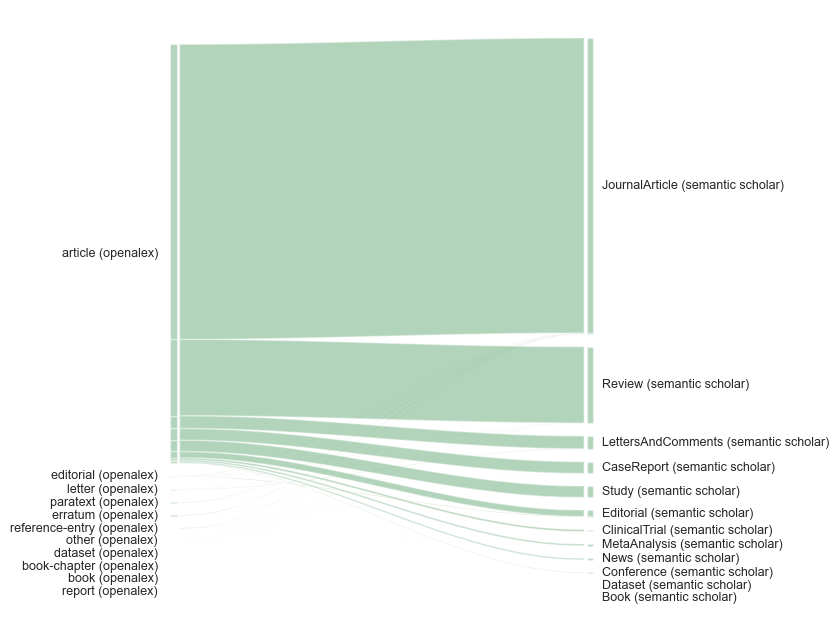

In [93]:
alluvial_plot(s2_oal_doctypes, 'oal_doctype', 's2_doctype', 'openalex', 'semantic scholar', 'openalex_s2', 6, 8)

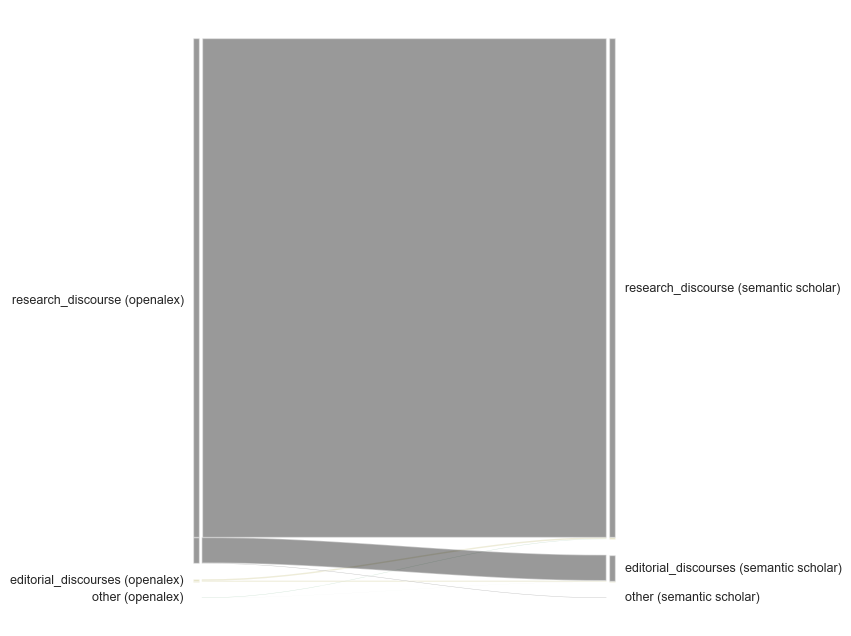

In [94]:
alluvial_plot_new_types(s2_oal_doctypes, 'oal_doctype', 's2_doctype', 'openalex', 'semantic scholar', 
                        openalex_type_mapping['journal'], s2_type_mapping['journal'], 'openalex_s2_new_clas', 6, 8)

In [101]:
openalex_s2_doctypes_journal = client.query(f"""
                SELECT oal.type AS oal_doctype, s2_pubtypes as s2_doctype, 
                       s2_sources.type AS s2_venuetype,
                       oal_sources.type AS oal_venuetype,
                       primary_location.source.display_name AS journal,
                       COUNT(DISTINCT(oal.doi)) AS n
                FROM {s2}.papers_2023_09_26 AS s2, UNNEST(publicationtypes) AS s2_pubtypes
                JOIN {openalex}.works AS oal
                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                LEFT JOIN {s2}.venues_2023_09_26 AS s2_sources
                    ON publicationvenueid =  s2_sources.id
                LEFT JOIN {openalex}.sources AS oal_sources
                    ON primary_location.source.id = oal_sources.id
                WHERE publication_year between 2012 AND 2022
                GROUP BY oal_doctype, s2_doctype, s2_venuetype, oal_venuetype, journal
                HAVING s2_venuetype = 'journal' AND oal_venuetype = 'journal'
                ORDER BY oal_doctype, s2_doctype
                """).to_dataframe()

In [102]:
openalex_s2_doctypes_journal['new_oal_type'] = openalex_s2_doctypes_journal.apply(
                                                    lambda row : mapping_types(openalex_type_mapping['journal'], 
                                                                               row['oal_doctype']), axis=1)
openalex_s2_doctypes_journal['new_s2_type'] = openalex_s2_doctypes_journal.apply(
                                                    lambda row : mapping_types(s2_type_mapping['journal'], 
                                                                               row['s2_doctype']), axis=1)

openalex_s2_doctypes_journal['type_match'] = (openalex_s2_doctypes_journal['new_oal_type']) == (openalex_s2_doctypes_journal['new_s2_type'])
openalex_s2_doctypes_journal['type_match'] = openalex_s2_doctypes_journal['type_match'].astype(int)

df1 = openalex_s2_doctypes_journal[openalex_s2_doctypes_journal.type_match == 1].groupby(['journal', 'new_oal_type'])['n'].sum().reset_index().rename(columns={'n': '1_sum'})
df2 = openalex_s2_doctypes_journal.groupby(['journal', 'new_oal_type'])['n'].sum().reset_index().rename(columns={'n': 'n_sum'})
df3 = pd.merge(df1, df2, on=['journal', 'new_oal_type'])
df3['prop'] = df3['1_sum'] / df3['n_sum']

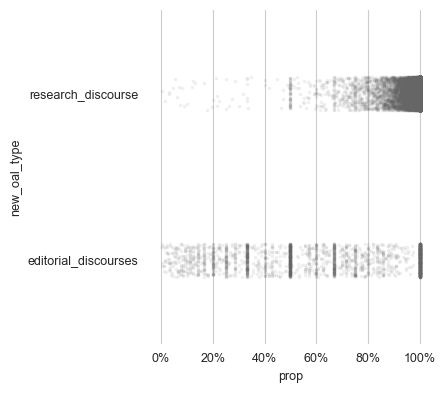

In [103]:
fig, ax = plt.subplots(figsize=(4.5, 4))

plt.box(False)

sns.stripplot(
    data=df3, 
    x='prop', 
    y='new_oal_type',
    marker='.',
    alpha=.1,
    edgecolor='#000000',
    color='#666666'
)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()